In [9]:
import os
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
from scipy.optimize import fsolve
from math import radians, log1p
import csv
from cmath import rect, sqrt, tan, sin, cos


Clonar repo para descargar archivos de materiales medidos:

In [10]:
!git clone https://github.com/tinchodeluca/ME2-PROY-SONDA.git

fatal: destination path 'ME2-PROY-SONDA' already exists and is not an empty directory.


Patrones de materiales

In [3]:
file_path = './ME2-PROY-SONDA/rsc/'
files = {}

for folder in os.listdir(file_path):
  if os.path.isdir(file_path + '/' + folder ):
    file_names = os.listdir( file_path + '/' + folder + '/' )
    files[folder] = file_names
    #print(file_names)

In [8]:
def vna_proc_file(file_path, file_name): #Procesa archivos S1P de VNA cuyas columnas son |Frec |Real{S11} |Imag{S11} |
    if ( file_path[-1] != '/' ):
      file_path += '/'
    file_path += file_name
    header_start  = '#'
    data_start    = '!'
    out_dict = {'Frec' : [],
                # 'Data' : [],
                # 'Index': [],
              }
    frecuencies = np.array([])
    reals       = np.array([])
    imgs        = np.array([])
    try:
        file = open(file_path, "r")
    except:
        print('TODO: No se puede abrir')
        return 404
    file_list = file.readlines()
    # print(file_list)
    file.close()
    for line in file_list[12:]: #De la linea 13 en adelante
        values      = line.strip().split('\t')
        frecuencies = np.append(frecuencies, np.float32(values[0]))
        reals       = np.append(reals, np.float32(values[1]))
        imgs        = np.append(imgs, np.float32(values[2]))
    # out_dict['Data'   ] = file_list[0:11]
    # out_dict['Index'  ] = file_list[11][1:].split(' ')
    out_dict['Frec'   ] = frecuencies
    out_dict['Complex'] = reals +1j*imgs

    return out_dict

def S11_to_Y11(frec, S11):
    z0 = 50
    y0 = 1/z0
    Y11 = y0*(( 1 - S11 ) / ( 1 + S11 ))
    return { 'Frec'    : frec,
             'Complex' : Y11,
            }

def SUBsample_S11 (small_dict, big_dict):
  if (len(small_dict['Frec']) < len(big_dict['Frec']) ):
    index = len(big_dict['Frec']) - 1
    while ( index >= 0 ):
        if( big_dict['Frec'][index] not in small_dict['Frec'] ):
            big_dict['Frec']    = np.delete(big_dict['Frec'], index)
            big_dict['Complex'] = np.delete(big_dict['Complex'], index)
        index -= 1
  else:
    print('El diccionario no es mas chico sino mas grande')

  if (len(small_dict) == len(big_dict) ):
    # print(big_dict)
    return big_dict

Patrones

In [5]:
def get_debye_model(frecs): #Patron agua destilada
    w     = frecs*2*np.pi
    E_inf = 4.6
    E_s   = 78.3
    tau   = 8.07e-12
    E_c   = E_inf + (E_s-E_inf)/(1-1j*w*tau)
    return E_c

def get_er_pat_alc_etilico(frecs):
    A = 4.505 + ((24.43 - 4.505) / (1 + 1j * frecs / (0.964e9))) - 1j * frecs * 0.056 / 1e9
    return np.real(A), -1j * np.imag(A)

def get_er_pat_alc_isopropilico(frecs):
    # curva del er complejo del isopropilico al 99 segun la curva de deybe
    ER = 3.065 + ((19.30 - 3.551) / (1 + 1j * frecs / (0.443e9))) + ((3.551 - 3.065) / (1 + 1j * frecs / (5.999e9)))
    return ER

In [11]:
subfolder  = '15-08-23'
big_dict   = vna_proc_file(file_path + subfolder, files[subfolder][2]) #2 ->Alcohol
file_path + subfolder + '/' + files[subfolder][2]

'./ME2-PROY-SONDA/rsc/15-08-23/Alcohol.s1p'

In [13]:
data = big_dict
print(data)

{'Frec': array([3.00000000e+04, 1.82999700e+06, 3.62999400e+06, ...,
       1.79964006e+10, 1.79982008e+10, 1.79999990e+10]), 'Complex': array([1.00344801+0.00051087j, 1.00617802+0.0016067j ,
       1.00316441+0.00117774j, ..., 0.65965152-0.26432401j,
       0.65990782-0.26445088j, 0.6591171 -0.26244771j])}


Funciones

In [ ]:
# Constants
Zo2 = 50
c = 299792458
er2 = 1
x1 = 0.00795 + 0.0025 + 0.08788
x2 = 0.0099 + 0.0366
uo = 1.2566370614E-6
eo = 8.854187817E-12
k = sqrt(uo / eo) / (2 * np.pi)
b = 0.0184
a = 0.008

def fun(xs, f, s11_mod, s11_ph):
    s11 = rect(s11_mod, radians(s11_ph))

    Ze2 = Zo2 * (1 + s11) / (1 - s11)

    lambda2 = c / (f * sqrt(er2))
    beta2 = 2 * np.pi / lambda2
    tg_betax2 = tan(beta2 * x2)

    Ze1_num = (1j * pow(Zo2, 2) * tg_betax2) - (Ze2 * Zo2)
    Ze1_den = (1j * Ze2 * tg_betax2) - Zo2
    Ze1 = Ze1_num / Ze1_den

    er1 = complex(*xs)
    lambda1 = c / (f * sqrt(er1))
    beta1 = 2 * np.pi / lambda1
    num = k * log1p(b / a) / sqrt(er1)
    den = 1j * tan(beta1 * x1)
    resul = (num / den) - Ze1
    return np.array([resul.real])  # Always return a 1D array

er1 = []

# Aire: 1
# Agua: 80
# Alcohol: 25
es = 1

frequencies    = data["Frec"]
complex_values = data["Complex"]

for f, s11_complex in zip(frequencies, complex_values):
    s11_mod, s11_phase = abs(s11_complex), np.angle(s11_complex, deg=True)

    try:
        [(er1_val,), _, ier, mesg] = fsolve(fun, x0=[es], args=(f, s11_mod, s11_phase), full_output=True)

        if mesg != 'The solution converged.':
            print(f"Warning at f = {f}: {mesg}")

    except Exception as e:
        print(f"Error at f = {f}: {str(e)}")
        continue

    er1.append((f, er1_val))




In [54]:
# Constants
Zo2 = 50
c = 299792458
er2 = 1
x1 = 0.00795+0.0025+0.08788
x2 = 0.0099+0.0366
uo = 1.2566370614E-6
eo = 8.854187817E-12
k = sqrt(uo/eo) / (2*np.pi)
b = 0.0184
a = 0.008

def fun(xs, f, s11_real, s11_img):
    er1 = complex(*xs)
    s11 = complex(s11_real, s11_img)
    lambda1 = c / (f*sqrt(er1))
    beta1 = 2 * np.pi / lambda1
    A = 1j * tan(beta1*x1)
    B = (1-s11) / (1+s11)
    resul = A - B
    return [resul.real, resul.imag]

er1 = []

file_name = "agua_55"

# Calculo de valores teoricos
er1_teorico=[]

#Aire: 1
#Agua: 80
#Alcohol: 25
es = 80
# es = 55
einf = 5.62
tau = 80E9

frec = 1E9
while(frec<=1E10):
    den = 1 + 1j*frec/tau
    er = einf + ((es-einf)/den)
    er1_teorico.append((er.real, er.imag))
    #print (frec/(2*np.pi)), er.real, er.imag
    frec = frec + 0.05E9

file_in = "/content/"+file_name+".csv"

i=0
with open(file_in, 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=';')
    for f_str, s11_mod_str, s11_phase_str in reader:
        f = float(f_str)
        s11_mod = float(s11_mod_str.replace(',','.'))
        s11_phase = float(s11_phase_str.replace(',','.'))
        [(er1_real,er1_imag), info, ier, mesg] = fsolve(fun, x0=[es, 0], args=(f, s11_mod, s11_phase), full_output=True)
        if mesg!='The solution converged.':
            i+=1-1
            # print(i+1,mesg)
        i = i+1
        er1.append((er1_real,er1_imag))

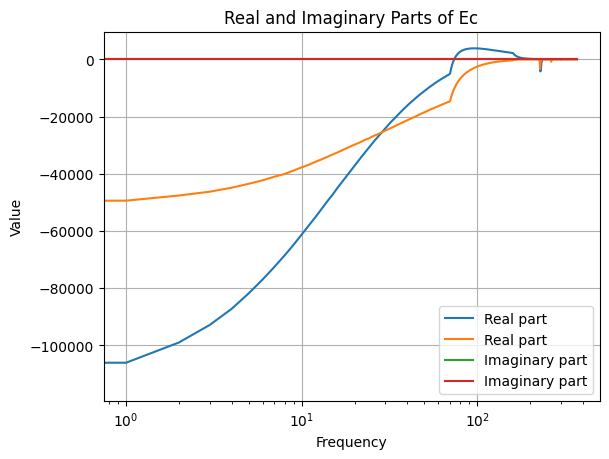

In [55]:
# Medido
plt.figure(2)
plt.plot( np.real(er1), label='Real part')
# Plot imaginary part
plt.plot(np.imag(er1), label='Imaginary part')
# Set labels and title
plt.title('Real and Imaginary Parts of Ec')
plt.xlabel('Frequency')
plt.ylabel('Value')
plt.xscale('log')
# Add a legend to distinguish real and imaginary parts
plt.legend()
# Display the plot
plt.grid(True)
plt.show()